In [1]:
import numpy as np
import transforms3d as tf3d
import scipy
from scipy import optimize, sort 
import pandas as pd
import matplotlib.pyplot as plt 
import pandas as pd
import json 
import os

log_path="./logs/avion/vol1/log_real_processed.csv"
raw_data=pd.read_csv(log_path)


In [2]:
#%% Prepocced data
  
prep_data=raw_data.drop(columns=[i for i in raw_data.keys() if (("forces" in i ) or ('pos' in i) or ("joy" in i)) ])
prep_data=prep_data.drop(columns=[i for i in raw_data.keys() if (("level" in i ) or ('Unnamed' in i) or ("index" in i)) ])



prep_data=prep_data.reset_index()

for i in range(3):
    prep_data['speed_pred[%i]'%(i)]=np.r_[prep_data['speed[%i]'%(i)].values[1:len(prep_data)],0]
    
    
prep_data['dt']=np.r_[prep_data['t'].values[1:]-prep_data['t'].values[:-1],0]
prep_data['t']-=prep_data['t'][0]
prep_data=prep_data.drop(index=[0,len(prep_data)-1])
prep_data=prep_data.reset_index()

data_prepared=prep_data[:len(prep_data)]



def scale_to_01(df):

    return (df-df.min())/(df.max()-df.min())

data_prepared.insert(data_prepared.shape[1],'omega_c[5]',(data_prepared['PWM_motor[5]']-1000)*925.0/1000)
"splitting the dataset into nsecs sec minibatches"


df=data_prepared.copy()


df.insert(data_prepared.shape[1],
          'R',
          [tf3d.quaternions.quat2mat([i,j,k,l]) for i,j,k,l in zip(df['q[0]'],df['q[1]'],df['q[2]'],df['q[3]'])])

R_array=np.array([i for i in df["R"]])


Aire_1,Aire_2,Aire_3,Aire_4,Aire_0 =    0.62*0.262* 1.292 * 0.5,\
                                    0.62*0.262* 1.292 * 0.5, \
                                    0.34*0.1* 1.292 * 0.5,\
                                    0.34*0.1* 1.292 * 0.5, \
                                    1.08*0.31* 1.292 * 0.5
                                    
Aire_list = [Aire_0,Aire_1,Aire_2,Aire_3,Aire_4]

cp_1,cp_2,cp_3,cp_4,cp_0 = np.array([-0.013,0.475,-0.040],       dtype=float).flatten(), \
                        np.array([-0.013,-0.475,-0.040],      dtype=float).flatten(), \
                        np.array([-1.006,0.17,-0.134],    dtype=float).flatten(),\
                        np.array([-1.006,-0.17,-0.134],   dtype=float).flatten(),\
                        np.array([0.021,0,-0.064],          dtype=float).flatten()
cp_list=[cp_0,cp_1,cp_2,cp_3,cp_4]

#0 : aile centrale
#1 : aile droite
#2 : aile gauche
#3 : vtail droit 
#4 : vtail gauche

theta=45.0/180.0/np.pi

Rvd=np.array([[1.0,0.0,0.0],
              [0.0,np.cos(theta),np.sin(theta)],
              [0.0,-np.sin(theta),np.cos(theta)]])

Rvg=np.array([[1.0,0.0,0.0],
              [0.0,np.cos(theta),-np.sin(theta)],
              [0.0,np.sin(theta),np.cos(theta)]])


forwards=[np.array([1.0,0,0])]*3
forwards.append(Rvd@np.array([1.0,0,0]))
forwards.append(Rvg@np.array([1.0,0,0]))

upwards=[np.array([0.0,0,-1.0])]*3
upwards.append(Rvd@np.array([0.0,0,-1.0]))
upwards.append(Rvg@np.array([0.0,0,-1.0]))

crosswards=[np.cross(i,j) for i,j in zip(forwards,upwards)]



def skew_to_x(S):
    SS=(S-S.T)/2
    return np.array([SS[1,0],SS[2,0],S[2,1]])

def skew(x):
    return np.array([[0,-x[2],x[1]],
                     [x[2],0,-x[0]],
                     [-x[1],x[0],0]])

omegas=np.zeros((R_array.shape[0],3))
omegas[1:]=[skew_to_x(j@(i.T)-np.eye(3)) for i,j in zip(R_array[:-1],R_array[1:])]
omegas[:,0]=omegas[:,0]*1.0/df['dt']
omegas[:,1]=omegas[:,1]*1.0/df['dt']
omegas[:,2]=omegas[:,2]*1.0/df['dt']

def filtering(X,k=0.05):
    Xnew=[X[0]]
    for i,x in enumerate(X[1:]):
        xold=Xnew[-1]
        xnew=xold+k*(x-xold)
        Xnew.append(xnew)
    return np.array(Xnew)

omegas_new=filtering(omegas)

v_ned_array=np.array([df['speed[%i]'%(i)] for i in range(3)]).T

v_body_array=np.array([(i.T@(j.T)).T for i,j in zip(R_array,v_ned_array)])

gamma_array=np.array([(i.T@(np.array([0,0,9.81]).T)).T for i in R_array])

for i in range(3):
    df.insert(df.shape[1],
              'speed_body[%i]'%(i),
              v_body_array[:,i])
    df.insert(df.shape[1],
              'gamma[%i]'%(i),
              gamma_array[:,i])
    df.insert(df.shape[1],
              'omega[%i]'%(i),
              omegas_new[:,i])
    
dragdirs=np.zeros((v_body_array.shape[0],3,5))
liftdirs=np.zeros((v_body_array.shape[0],3,5))
slipdirs=np.zeros((v_body_array.shape[0],3,5))

alphas=np.zeros((v_body_array.shape[0],1,5))
sideslips=np.zeros((v_body_array.shape[0],1,5))

for k,v_body in enumerate(v_body_array):
    
    
    v_in_ldp=np.cross(crosswards,np.cross((v_body-np.cross(cp_list,omegas_new[k])),crosswards))
    
    dd=-v_in_ldp
    dd=dd.T@np.diag(1.0/(np.linalg.norm(dd,axis=1)+1e-8))

    ld=np.cross(crosswards,v_in_ldp)
    ld=ld.T@np.diag(1.0/(np.linalg.norm(ld,axis=1)+1e-8))
              
    sd=-(v_body-np.cross(cp_list,omegas_new[k])-v_in_ldp)
    sd=sd.T@np.diag(1.0/(np.linalg.norm(sd,axis=1)+1e-8))
    
    dragdirs[k,:,:]=R_array[k]@(dd@np.diag(Aire_list)*np.linalg.norm(v_in_ldp)**2)
    liftdirs[k,:,:]=R_array[k]@(ld@np.diag(Aire_list)*np.linalg.norm(v_in_ldp)**2)
    slipdirs[k,:,:]=R_array[k]@(sd@np.diag(Aire_list)*np.linalg.norm(v_in_ldp)**2)
    
#     alphas_d=np.diag(v_in_ldp@(np.array(forwards).T))/(np.linalg.norm(v_in_ldp,axis=1)+1e-8)
#     alphas_d=np.arccos(alphas_d)
#     alphas_d=np.sign(np.diag(v_in_ldp@np.array(upwards).T))*alphas_d
    xalpha=np.diag(v_in_ldp@(np.array(forwards).T))/(np.linalg.norm(v_in_ldp,axis=1)+1e-8)
    yxalpha=np.diag(v_in_ldp@(np.array(upwards).T))/(np.linalg.norm(v_in_ldp,axis=1)+1e-8)

    alphas_d=np.arctan2(yxalpha,xalpha) 
    
    x=np.linalg.norm(v_in_ldp,axis=1)
    y=np.linalg.norm(v_body-np.cross(cp_list,omegas_new[k])-v_in_ldp,axis=1)
    sideslips_d=np.arctan2(y,x)
        
    alphas[k,:,:]=alphas_d
    sideslips[k,:,:]=sideslips_d

    
df.insert(df.shape[1],
          'liftdirs',
          [i for i in liftdirs])
        
df.insert(df.shape[1],
          'dragdirs',
          [i for i in dragdirs])     

df.insert(df.shape[1],
          'slipdirs',
          [i for i in slipdirs])  
        
df.insert(df.shape[1],
          'alphas',
          [i for i in alphas])    

df.insert(df.shape[1],
          'sideslips',
          [i for i in sideslips])    

df.insert(df.shape[1],
          'thrust_dir_ned',
          [i[:,0]*j**2 for i,j in zip(df['R'],df['omega_c[5]'])])

import numpy as np
delt=np.array([df['PWM_motor[%i]'%(i)] for i in range(1,5)]).T
delt=np.concatenate((np.zeros((len(df),1)),delt),axis=1).reshape(-1,1,5)
delt=(delt-1530)/500*15.0/180.0*np.pi
delt[:,:,0]*=0
delt[:,:,2]*=-1.0
delt[:,:,4]*=-1.0

df.insert(df.shape[1],
          'deltas',
          [i for i in delt])



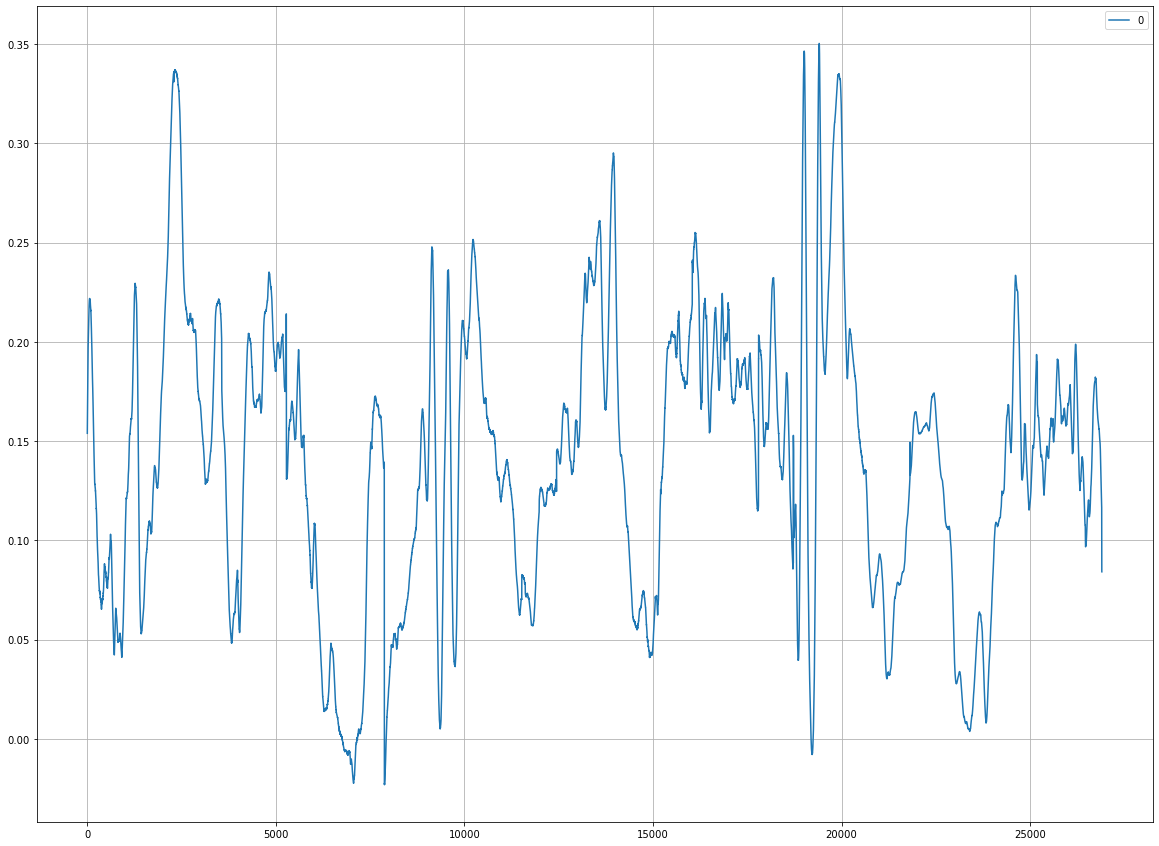

In [3]:
for j in range(1):
    plt.figure(figsize=(20,15))
    alpha=[df['alphas'].iloc[[i]].values[0][0][j]+0.100205*(15*np.pi/180) for i in range(len(df))] 
    plt.plot(alpha, label=str(j))
    plt.legend()
plt.grid()

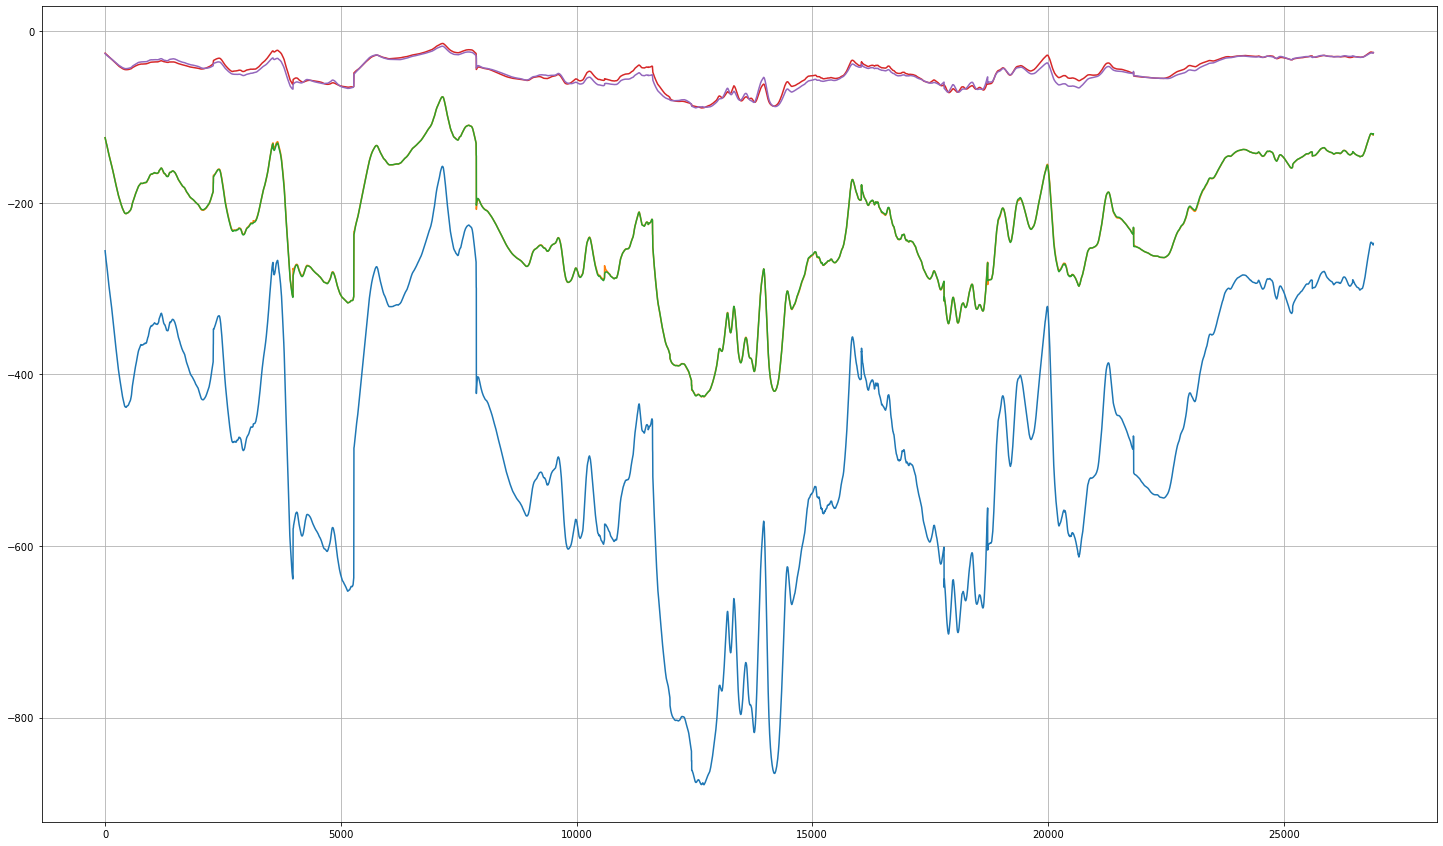

In [4]:
plt.figure(figsize=(25,15))

plt.plot(np.array([i[2,:] for i in df['liftdirs']]))
plt.grid()

In [5]:

def compute_params_simple():
    ct = 1.1e-4
    a_0 =  0.07
    a_s =  0.3391
    d_s =  15.0*np.pi/180
    cl1sa = 5
    cd1fp = 2.5
    k0 = 0.1
    k1 = 0.1
    k2 = 0.1
    cd0fp =  1e-2
    cd0sa = 0.3
    cd1sa = 1.0
    m= 8.5

    coeffs_0=np.array([ct,
                     a_0,
                     a_s,
                     d_s, 
                     cl1sa, 
                     cd1fp, 
                     k0, k1, k2, 
                     cd0fp, 
                     cd0sa, cd1sa,m])
    return coeffs_0

coeffs_0=compute_params_simple()

def dyn(df=df,coeffs=coeffs_0,fix_mass=False,fix_ct=False):

    ct,a_0, a_s, d_s, cl1sa, cd1fp, k0, k1, k2, cd0fp, cd0sa, cd1sa,m=coeffs
    
    ct= 2.0*1.1e-4 if fix_ct else ct
    m= 8.5 if fix_mass else m
    
    "compute aero coeffs "
    
    a=np.array([i for i in df['alphas']])
    d_0=np.array([i for i in df['deltas']])
    a_0_arr=a_0*np.ones(d_0.shape)
    a_0_arr[:,-2:]*=0
    
    CL_sa = 1/2 * cl1sa * np.sin(2*(a + (k1*d_0) + a_0))
    CD_sa = cd0sa + cd1sa * np.sin((a + (k0*d_0) + a_0))**2

    CL_fp = 1/2 * cd1fp * np.sin((2*(a+ (k1*d_0) + a_0)))
    CD_fp = cd0fp + cd1fp * np.sin((a + (k0*d_0) + a_0))**2

    puiss=5
    s = 1.0 - ((a+a_0)**2/a_s**2)**puiss/(((a+a_0)**2/a_s**2)**puiss + 100+200*d_s)

    C_L = CL_fp + s*(CL_sa - CL_fp) + k2 * np.sin(d_0)
    C_D = CD_fp + s*(CD_sa - CD_fp)
    
    #C_L,C_D shape is (n_samples,1,n_surfaces)
    
    # lifts,drags
    ld,dd=np.array([i for i in df['liftdirs']]),np.array([i for i in df['dragdirs']])
    
    lifts=C_L*ld    
    drags=C_D*dd
    
    aeroforce_total=np.sum(lifts+drags,axis=2)
    
    # "compute thrust  "

    T=ct*np.array([i for i in df['thrust_dir_ned']])
    g=np.zeros(aeroforce_total.shape)
    g[:,-1]+=9.81
    forces_total=T+aeroforce_total+m*g
    acc=forces_total/m
    return acc

def compute_params_complex():
    ct = 1.1e-4
    a_0 =  0.07
    a_s =  0.3391
    d_s =  15.0*np.pi/180
    cl1sa = 5
    cd1fp = 2.5
    k0 = 0.1
    k1 = 0.1
    k2 = 0.1
    cd0fp =  1e-2
    cs= 0.5
    cl1fp=5
    cd0sa = 0.3
    cd1sa = 1.0
    m= 8.5
    
    coeffs_0_complex=np.array([ct,
                        a_0,
                        a_s,
                        d_s, 
                        cl1sa, 
                        cl1fp,
                        k0, k1, k2, 
                        cs,
                        cd0fp, cd0sa, 
                        cd1sa, cd1fp,
                        a_0,
                        a_s,
                        d_s, 
                        cl1sa, 
                        cl1fp,
                        k0, k1, k2,
                        cs,
                        cd0fp, cd0sa, 
                        cd1sa, cd1fp,
                        m])
    return coeffs_0_complex
coeffs_0_complex=compute_params_complex()


def dyn_complex(df=df,coeffs=coeffs_0_complex,fix_mass=False,fix_ct=False,no_slip=False):
    
    ct,\
    a_0, a_s, d_s, cl1sa, cl1fp, k0, k1, k2, cs, cd0fp, cd0sa, cd1sa, cd1fp, \
    a_0_v, a_s_v, d_s_v, cl1sa_v, cl1fp_v, k0_v, k1_v, k2_v, cs_v, cd0fp_v, cd0sa_v, cd1sa_v, cd1fp_v, \
    m=coeffs
    
    ct= 1.1e-4 if fix_ct else ct
    m= 8.5 if fix_mass else m
    
    "compute aero coeffs "

    a=np.array([i for i in df['alphas']])
    sideslip=np.array([i for i in df['sideslips']])
    d_0=np.array([i for i in df['deltas']])
    
    a_0_arr=np.ones(d_0.shape)@np.diag([a_0,a_0,a_0,a_0_v,a_0_v])

    k0d0=d_0@np.diag([k0,k0,k0,k0_v,k0_v])
    k1d0=d_0@np.diag([k1,k1,k1,k1_v,k1_v])

    
    
    CL_sa = 1/2  * np.sin(2*(a + (k1d0) + a_0_arr)) @ np.diag([cl1sa,
                                                           cl1sa,
                                                           cl1sa,
                                                           cl1sa_v,
                                                           cl1sa_v])
    
    CD_sa = np.ones(a.shape)@ np.diag([cd0sa,
                                        cd0sa,
                                        cd0sa,
                                        cd0sa_v,
                                        cd0sa_v])
    
    CD_sa = CD_sa + np.sin((a + (k0d0) + a_0_arr))**2 @ np.diag([cd1sa,
                                                           cd1sa,
                                                           cd1sa,
                                                           cd1sa_v,
                                                           cd1sa_v])
    
    
    

    CL_fp = 1/2  * np.sin(2*(a + (k1d0) + a_0_arr)) @ np.diag([cl1fp,
                                                           cl1fp,
                                                           cl1fp,
                                                           cl1fp_v,
                                                           cl1fp_v])
    
    CD_fp = np.ones(a.shape)@ np.diag([cd0fp,
                                        cd0fp,
                                        cd0fp,
                                        cd0fp_v,
                                        cd0fp_v])
    
    CD_fp = CD_fp + np.sin((a + (k0d0) + a_0_arr))**2 @ np.diag([cd1fp,
                                                           cd1fp,
                                                           cd1fp,
                                                           cd1fp_v,
                                                           cd1fp_v])
    
    

    puiss=5
    s = - ((a+a_0)**2 @(np.diag(1.0/np.array([a_s,
                                              a_s,
                                              a_s,
                                              a_s_v,
                                              a_s_v])))**2)**puiss
    s = s @ (((a+a_0)**2@(np.diag(1.0/np.array([a_s,
                                                a_s,
                                                a_s,
                                                a_s_v,
                                                a_s_v])))**2)**puiss+ 100+200* np.diag([ d_s,
                                                                                        d_s,
                                                                                        d_s
                                                                                        ,d_s_v,
                                                                                        d_s_v]))
    s = s+1
    
    
    C_L = CL_fp + s*(CL_sa - CL_fp) 
    C_L = C_L + np.sin(d_0)@np.diag([k2,k2,k2,k2_v,k2_v])
    C_D = CD_fp + s*(CD_sa - CD_fp)
    C_S =np.sin(sideslip)@np.diag([cs,cs,cs,cs_v,cs_v])
    #C_L,C_D shape is (n_samples,1,n_surfaces)

    # lifts,drags
    ld,dd=np.array([i for i in df['liftdirs']]),np.array([i for i in df['dragdirs']])
    sd=np.array([i for i in df['sideslips']])
    
    lifts=C_L*ld    
    drags=C_D*dd
    sweep=C_S*sd
    # aeroforce_total=np.sum(lifts+drags,axis=2)
    aeroforce_total=np.sum(lifts+drags,axis=2)  if no_slip else  np.sum(lifts+drags+sweep,axis=2) 
    # "compute thrust  "

    T=ct*np.array([i for i in df['thrust_dir_ned']])
    g=np.zeros(aeroforce_total.shape)
    g[:,-1]+=9.81
    forces_total=T+aeroforce_total+m*g
    acc=forces_total/m
    
    return acc

In [6]:
#%% modeling with new params 
opti_path = "./scipy_solve/"
for name in np.sort(os.listdir(opti_path)):
    if ".json" in name:
        with open(opti_path+name,'r') as f:
            print(name)
            opti_params = json.load(f)
            coeff_complex =opti_params['X']  

COMPLEX_GOODINIT_meth_L-BFGS-B_fm_False_fc_False_sideslip_False.json
COMPLEX_GOODINIT_meth_L-BFGS-B_fm_False_fc_False_sideslip_True.json
COMPLEX_GOODINIT_meth_L-BFGS-B_fm_False_fc_True_sideslip_False.json
COMPLEX_GOODINIT_meth_L-BFGS-B_fm_False_fc_True_sideslip_True.json
COMPLEX_GOODINIT_meth_L-BFGS-B_fm_True_fc_False_sideslip_False.json
COMPLEX_GOODINIT_meth_L-BFGS-B_fm_True_fc_False_sideslip_True.json
COMPLEX_GOODINIT_meth_L-BFGS-B_fm_True_fc_True_sideslip_False.json
COMPLEX_GOODINIT_meth_L-BFGS-B_fm_True_fc_True_sideslip_True.json
COMPLEX_INITONES_BOUNDED_meth_L-BFGS-B_fm_False_fc_False_sideslip_False.json
COMPLEX_INITONES_BOUNDED_meth_L-BFGS-B_fm_False_fc_False_sideslip_True.json
COMPLEX_INITONES_BOUNDED_meth_L-BFGS-B_fm_False_fc_True_sideslip_False.json
COMPLEX_INITONES_BOUNDED_meth_L-BFGS-B_fm_False_fc_True_sideslip_True.json
COMPLEX_INITONES_BOUNDED_meth_L-BFGS-B_fm_True_fc_False_sideslip_False.json
COMPLEX_INITONES_BOUNDED_meth_L-BFGS-B_fm_True_fc_False_sideslip_True.json
COMPL

In [19]:
def plot_result_opti(name) : 
    with open(opti_path+name,'r') as f:
        opti_params = json.load(f)
        coeff =opti_params['X']


    if "fm_False" in name:
        fix_mass=False
    else:
        fix_mass=True
    if "fc_False" in name:
        fix_ct=False
    else:
        fix_ct=True
    if "sideslip_False" in name:
        no_slip=True
    else:
        no_slip=False
    if "COMPLEX" in name:
            if "BFGS" in name:
                if "INITONES" in name:
                    init="INITONES/BFGS/"
                elif "GOODINIT" in name:
                    init="GOODINIT/BFGS/"
            else:
                if "INITONES" in name:
                    init="INITONES/SLSQP/"
                elif "GOODINIT" in name:
                    init="GOODINIT/SLSQP/"
    else :
            if "BFGS" in name:
                init='SIMPLE/BFGS/'
            else:
                init='SIMPLE/SLSQP/'
            X0=coeffs_0

    coeff[4]=-0.5
    coeff[5]=0
#     coeff[10]=2*0
#     coeff[13]*=1
    
#     coeff[12]=1
#     coeff[11]=0.086200*1

    if "COMPLEX" in name :
        y_pred=dyn_complex(df=df,coeffs=coeff,fix_mass=fix_mass, fix_ct=fix_ct, no_slip=no_slip)
    elif "SIMPLE" in name:
        y_pred=dyn(df=df,coeffs=(coeff*X0),fix_mass=fix_mass, fix_ct=fix_ct)

    y_log=np.array([df['acc['+str(i)+']'] for i in range(3)])
    y_log_label="acc"

    fig=plt.figure(figsize=(35,15))
    fig.suptitle(name +' Cost : '+str(opti_params['cost']))
    RMS_error_total=0
    for i in range(3):
        fig.add_subplot(3,1,i+1)
        RMS_error =  abs(y_pred[:,i] - y_log[i,:])**2
        RMS_error = np.sqrt(np.mean(RMS_error))
        RMS_error_total+=RMS_error
        plt.plot(df['t'], y_log[i,:], label=y_log_label+"_real["+str(i)+"]", color='black')
        plt.plot(df['t'], y_pred[:,i], label=y_log_label+"_pred["+str(i)+"]", color='red', alpha=0.8)
        plt.title('RMS error : '+str(RMS_error))
        # plt.ylim([np.min(y_log[i,:]), np.max(y_log[i,:])])
        plt.ylabel('Force (N)')
        plt.xlabel('Time (s)')
        plt.grid()
        plt.legend()
    print(RMS_error_total)
    return 

13.51747858003303


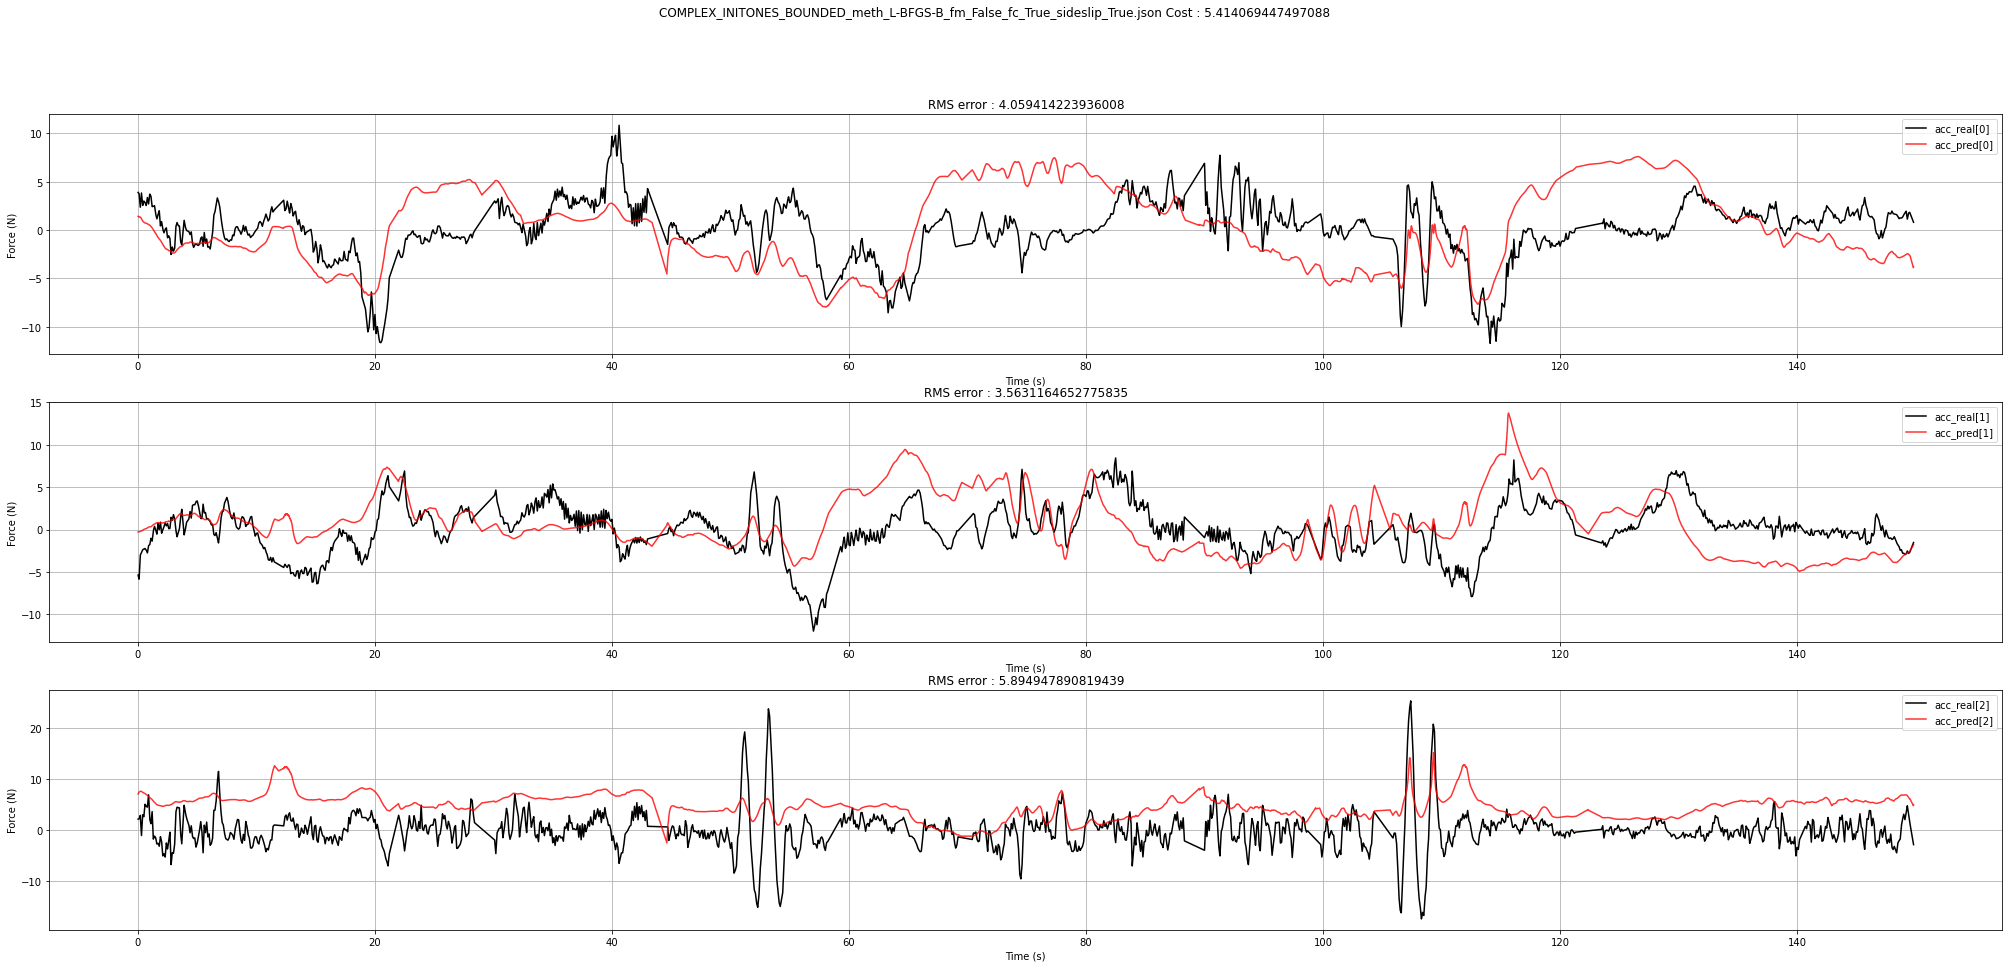

In [20]:
plot_result_opti("COMPLEX_INITONES_BOUNDED_meth_L-BFGS-B_fm_False_fc_True_sideslip_True.json")

38.79916429855464


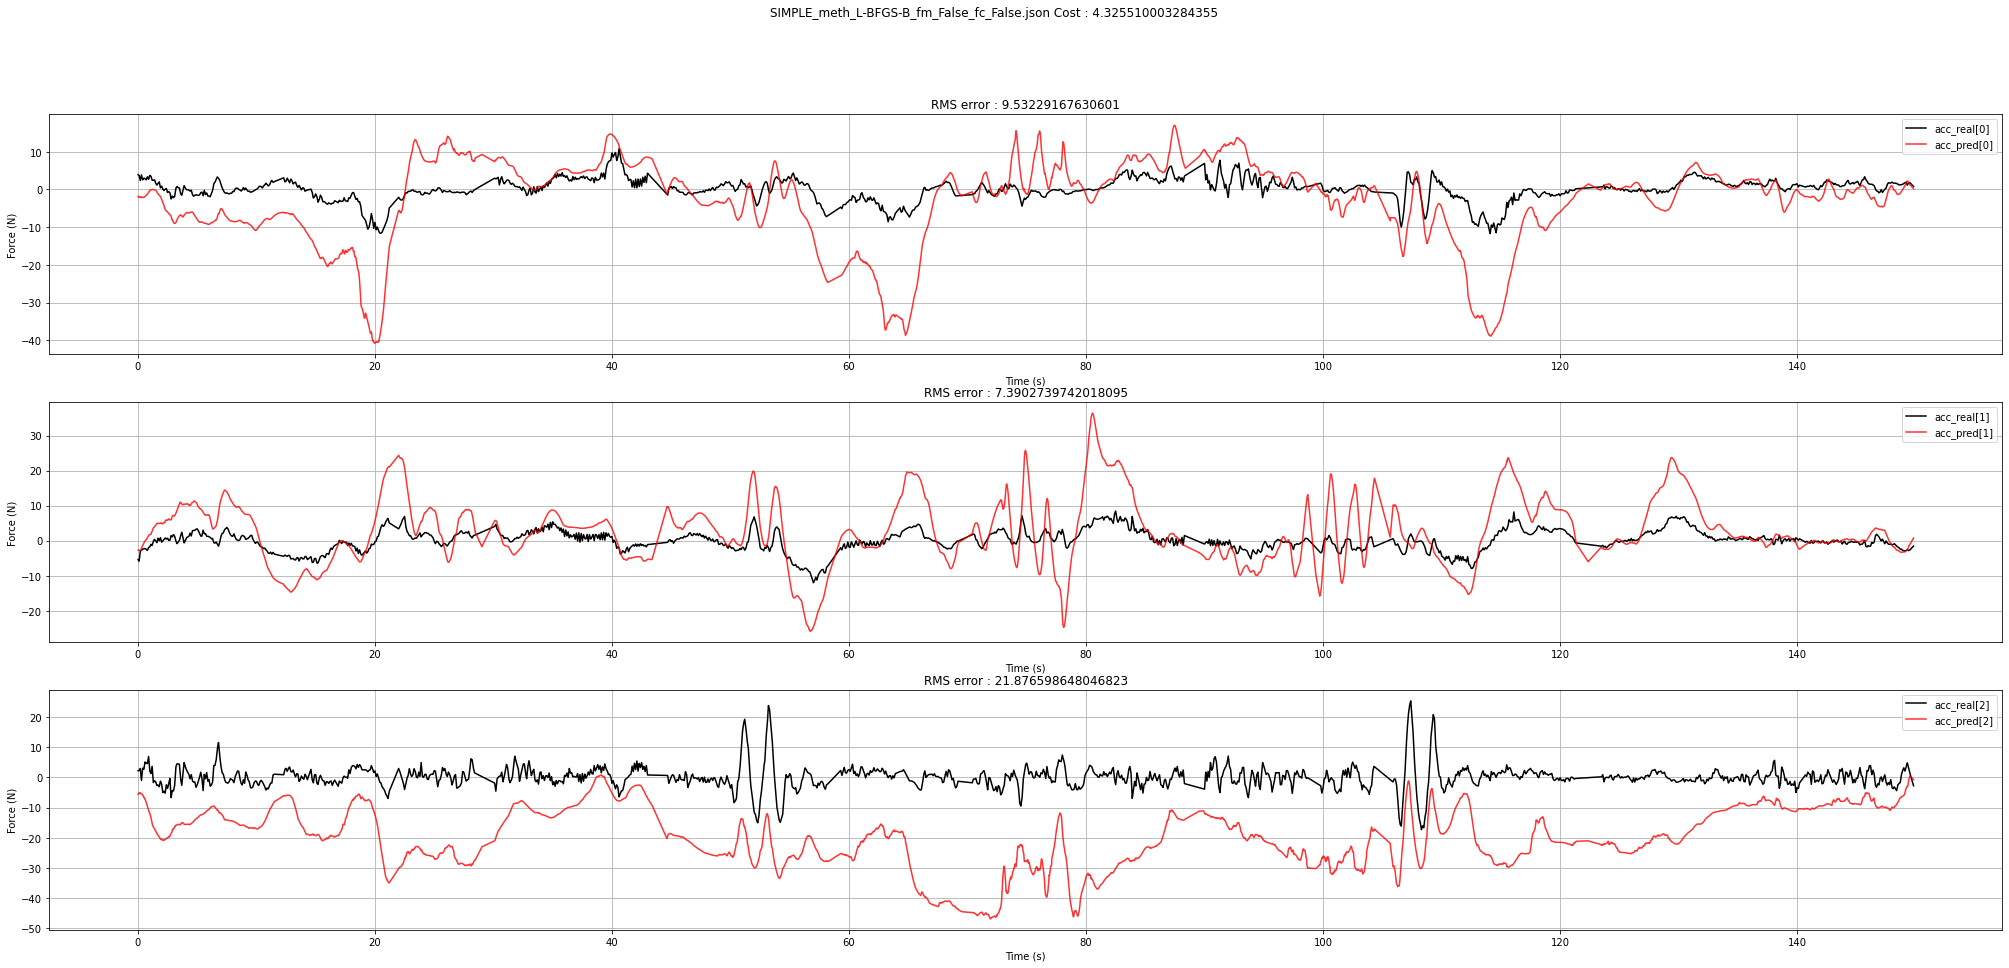

In [21]:
plot_result_opti("SIMPLE_meth_L-BFGS-B_fm_False_fc_False.json")

76.67640388701889


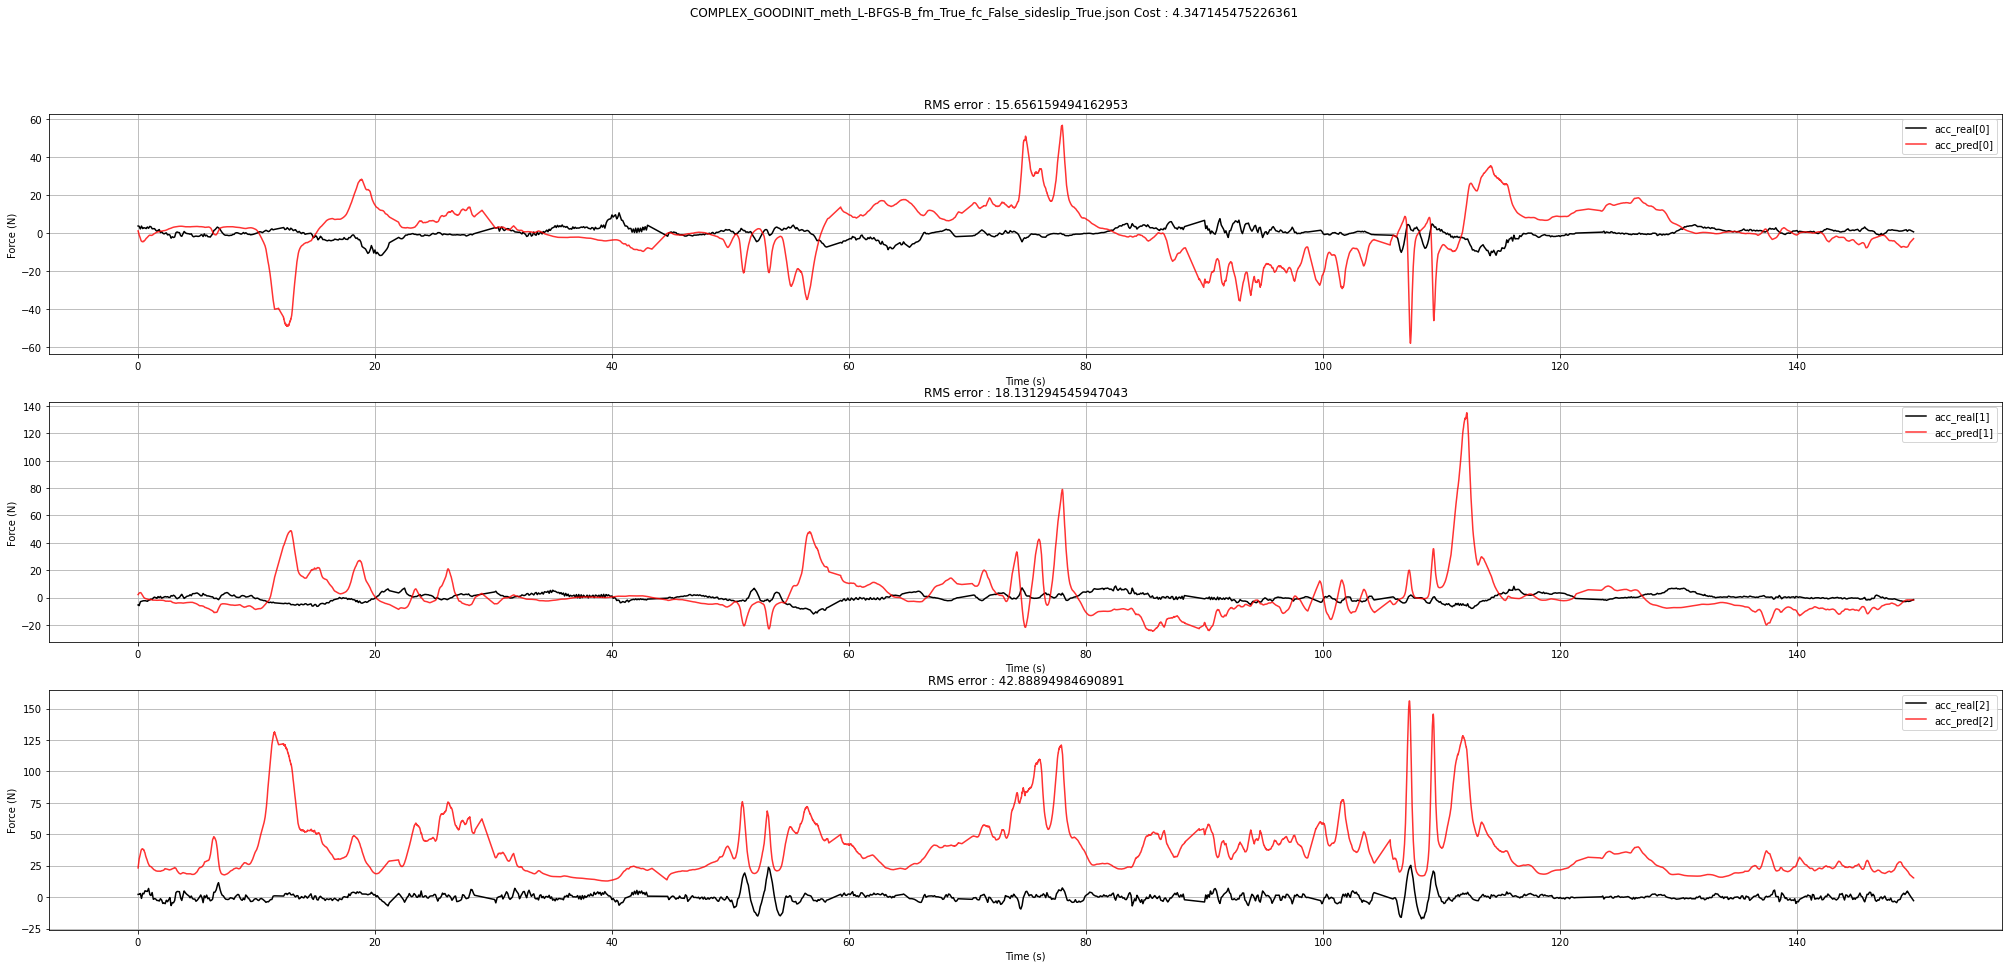

In [10]:
plot_result_opti('COMPLEX_GOODINIT_meth_L-BFGS-B_fm_True_fc_False_sideslip_True.json')